In [ ]:
# Advanced AQUA
# Amitava Chakraborty 04 Feb, 2020

from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.finance.ising import portfolio
from qiskit.optimization.ising.common import sample_most_likely
from qiskit.finance.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import VQE, QAOA, ExactEigensolver
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.variational_forms import RY
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import datetime

from qiskit import IBMQ
provider = IBMQ.load_account()

In [14]:
# set number of assets (= number of qubits)
num_assets = 4

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
print(stocks)

data = RandomDataProvider(tickers=stocks,
                 start=datetime.datetime(2016,1,1),
                 end=datetime.datetime(2016,1,30))
data.run()

print(data._data)
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()
print(mu)
print(sigma)

['TICKER0', 'TICKER1', 'TICKER2', 'TICKER3']
[[100.09432289112054, 100.24752659132031, 101.04697031185454, 98.32605935495143, 98.43661226592371, 100.72720534283211, 102.56586695975203, 102.32928328561526, 101.86545971263237, 99.38998224372868, 99.62824270217949, 99.55310259564119, 98.455828860641, 97.80294349732016, 97.45512195918309, 96.02358774065839, 97.26048609474526, 98.05008127907358, 98.83210925104052, 97.20987442885792, 97.50944097221927, 97.54594074291255, 95.93471996808641, 97.72043274408284, 97.65226670263854, 97.84533550392689, 96.80870186583398, 98.05193273026002, 98.32048143750357], [96.88546925154681, 97.62237259614864, 95.30831263098389, 94.4839158061435, 94.04980243065508, 94.42544942775454, 94.47379062450587, 94.27563077691661, 95.77871370433752, 96.7551833500144, 98.35930354490425, 97.88328842507292, 100.12211851431262, 101.2598716897691, 102.99648003759626, 105.21938731932232, 103.96175194502345, 105.55465471734709, 106.51730897446424, 107.96786984926098, 106.641306

In [19]:
q = 0.1 # set risk factor
budget = int(num_assets / 2) # set budget
penalty = num_assets # set parameter to scale the budget penalty term

qubitOp, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)
print(qubitOp)
print(offset)

Representation: paulis, qubits: 4, size: 10
3.9991920775936354


In [20]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = sample_most_likely(result['eigvecs'][0])
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))

    probabilities = np.abs(result['eigvecs'][0])**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = portfolio.portfolio_value(x, mu, sigma, q, budget, penalty)    
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

In [21]:
exact_eigensolver = ExactEigensolver(qubitOp, k=1)
result = exact_eigensolver.run()

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Optimal: selection [0. 1. 1. 0.], value -0.0100

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 1 0]	-0.0100		1.0000
 [1 1 1 1]	15.9984		0.0000
 [0 1 1 1]	3.9978		0.0000
 [1 0 1 1]	4.0020		0.0000
 [0 0 1 1]	0.0014		0.0000
 [1 1 0 1]	4.0048		0.0000
 [0 1 0 1]	0.0042		0.0000
 [1 0 0 1]	0.0083		0.0000
 [0 0 0 1]	4.0077		0.0000
 [1 1 1 0]	3.9906		0.0000
 [1 0 1 0]	-0.0058		0.0000
 [0 0 1 0]	3.9936		0.0000
 [1 1 0 0]	-0.0030		0.0000
 [0 1 0 0]	3.9964		0.0000
 [1 0 0 0]	4.0006		0.0000
 [0 0 0 0]	16.0000		0.0000


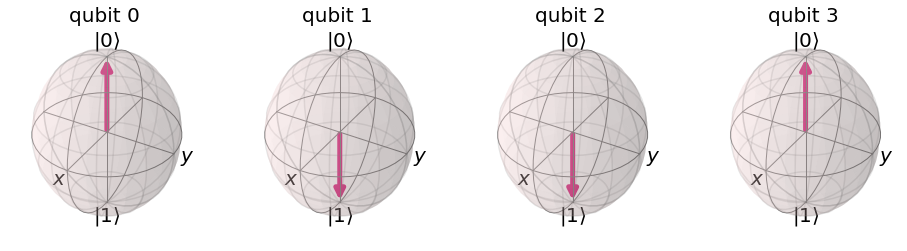

In [22]:
print(result['eigvecs'][0])
print_result(result)
plot_bloch_multivector(result['eigvecs'][0])

In [ ]:
backend = BasicAer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = RY(qubitOp.num_qubits, depth=3, entanglement='full')
vqe = VQE(qubitOp, ry, cobyla)
vqe.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

print_result(result)